# Import dependencies

In [62]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np 
import tensorflow as tf 
import re 
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score
import seaborn as sns 

from wordcloud import WordCloud,STOPWORDS
plt.style.use('ggplot')


# Data preprocessing

In [63]:
fake_df = pd.read_csv('Fake.csv')
real_df = pd.read_csv('True.csv')

In [64]:
real_df.isnull().sum()

title      0
text       0
subject    0
date       0
dtype: int64

In [65]:
fake_df.isnull().sum()

title      0
text       0
subject    0
date       0
dtype: int64

In [66]:
fake_df.subject.unique()

array(['News', 'politics', 'Government News', 'left-news', 'US_News',
       'Middle-east'], dtype=object)

In [67]:
real_df.subject.unique()

array(['politicsNews', 'worldnews'], dtype=object)

In [68]:
fake_df.drop(['date', 'subject'], axis=1, inplace=True)
real_df.drop(['date', 'subject'], axis=1, inplace=True)

**add classes**

In [69]:
fake_df['class'] = 0 
real_df['class'] = 1

**check imbalance**

Difference in news articles: 2064


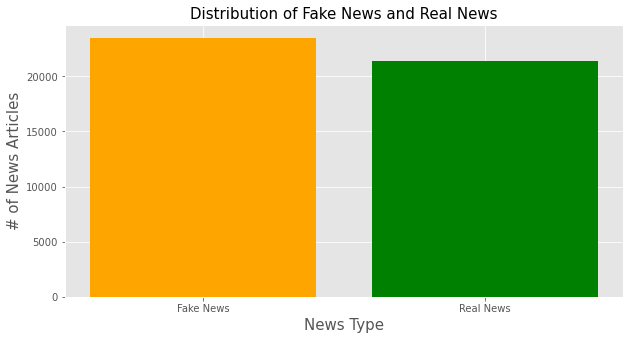

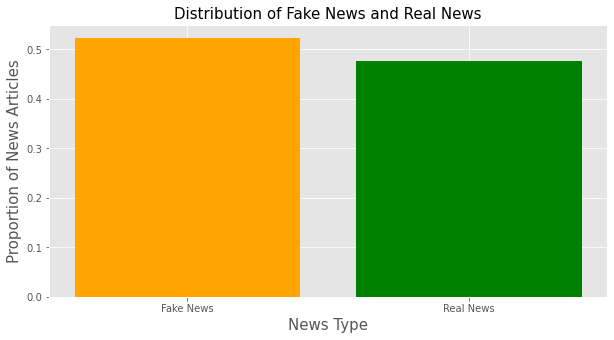

In [70]:
plt.figure(figsize=(10, 5))
plt.bar('Fake News', len(fake_df), color='orange')
plt.bar('Real News', len(real_df), color='green')
plt.title('Distribution of Fake News and Real News', size=15)
plt.xlabel('News Type', size=15)
plt.ylabel('# of News Articles', size=15)


total_len = len(fake_df) + len(real_df)
plt.figure(figsize=(10, 5))
plt.bar('Fake News', len(fake_df) / total_len, color='orange')
plt.bar('Real News', len(real_df) / total_len, color='green')
plt.title('Distribution of Fake News and Real News', size=15)
plt.xlabel('News Type', size=15)
plt.ylabel('Proportion of News Articles', size=15)

print('Difference in news articles:',len(fake_df)-len(real_df))

**Concatenate data set for training**

In [71]:
news_df = pd.concat([fake_df, real_df], ignore_index=True, sort=False)
news_df['text'] = news_df['title'] + news_df['text']
news_df.drop('title', axis=1, inplace=True)
news_df.head()

,text,class
0,Donald Trump Sends Out Embarrassing New Year’...,0
1,Drunk Bragging Trump Staffer Started Russian ...,0
2,Sheriff David Clarke Becomes An Internet Joke...,0
3,Trump Is So Obsessed He Even Has Obama’s Name...,0
4,Pope Francis Just Called Out Donald Trump Dur...,0


In [72]:
news_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    44898 non-null  object
 1   class   44898 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 701.7+ KB


**data cleaning**

delete stopword like is/the/an, etc.

In [117]:
from bs4 import BeautifulSoup
import re,string,unicodedata

def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

def remove_between_square_brackets(text):
    #Removing the square brackets
    temp = re.sub('\[[^]]*\].-', '', text)
    # Removing URL's
    return re.sub(r'http\S+', '', temp)

#Removing the stopwords from text
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in STOPWORDS:
            final_text.append(i.strip())
    return " ".join(final_text)

#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_stopwords(text)
    return text

#Apply function on review column
news_df['text']=news_df['text'].apply(denoise_text)

**Word Cloud**

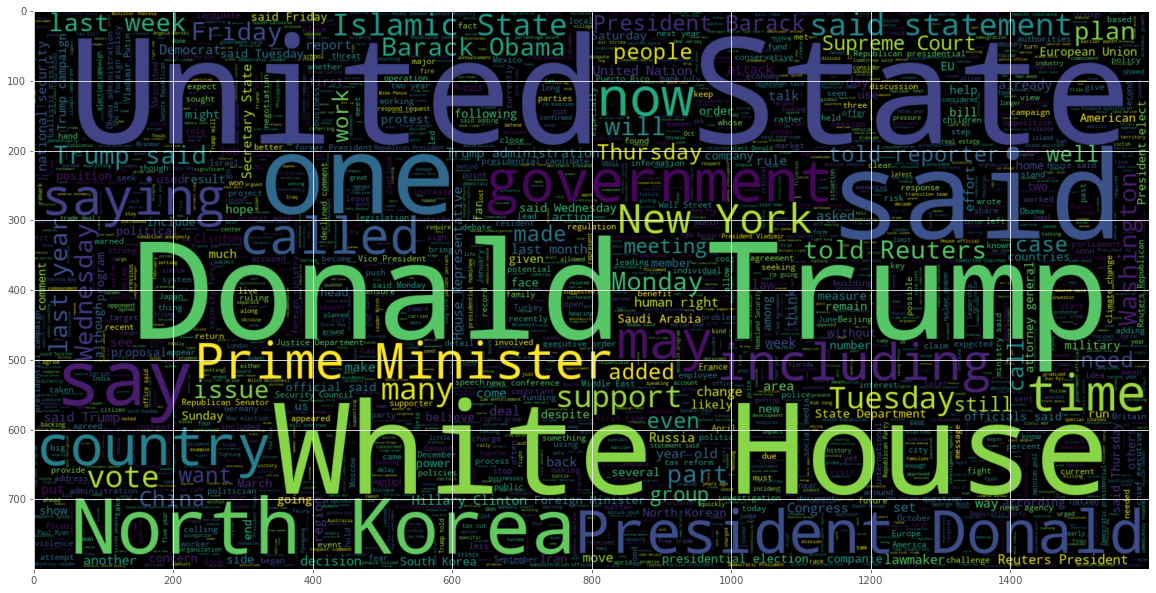

In [102]:
#true word cloud
plt.figure(figsize = (20,20)) # Text that is not Fake
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(" ".join(news_df[news_df['class']== 1].text))
plt.imshow(wc , interpolation = 'bilinear')

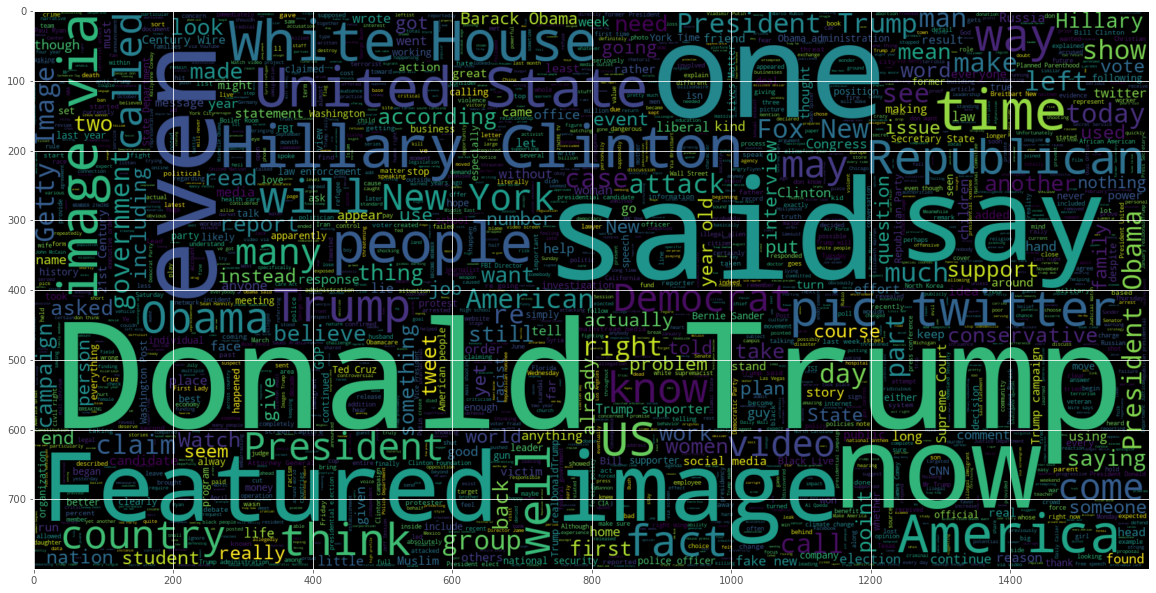

In [103]:
#true word cloud
plt.figure(figsize = (20,20)) # Text that is not Fake
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(" ".join(news_df[news_df['class']== 0].text))
plt.imshow(wc , interpolation = 'bilinear')

**Number of characters in texts**

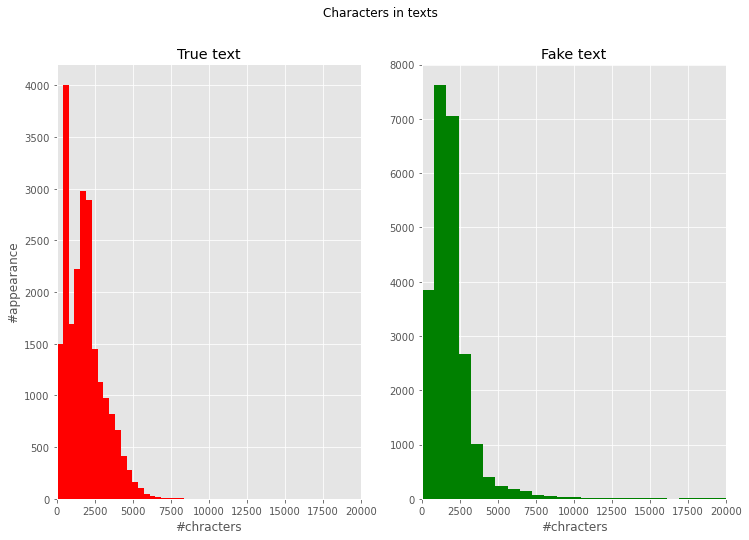

In [105]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,8))
text_len=news_df[news_df['class']==1]['text'].str.len()
ax1.hist(text_len,50,color='red')
ax1.set_title('True text')
ax1.set_xlabel('#chracters')
ax1.set_xlim(0, 20000) #cut extreme long 
ax1.set_ylabel('#appearance')
text_len=news_df[news_df['class']==0]['text'].str.len()
ax2.hist(text_len,50,color='green')
ax2.set_title('Fake text')
ax2.set_xlabel('#chracters')
ax2.set_xlim(0, 20000)
fig.suptitle('Characters in texts')
plt.show()

From the above figures we find that **characters** in true/false texts are of different distributions. 

**Number of words in each text**

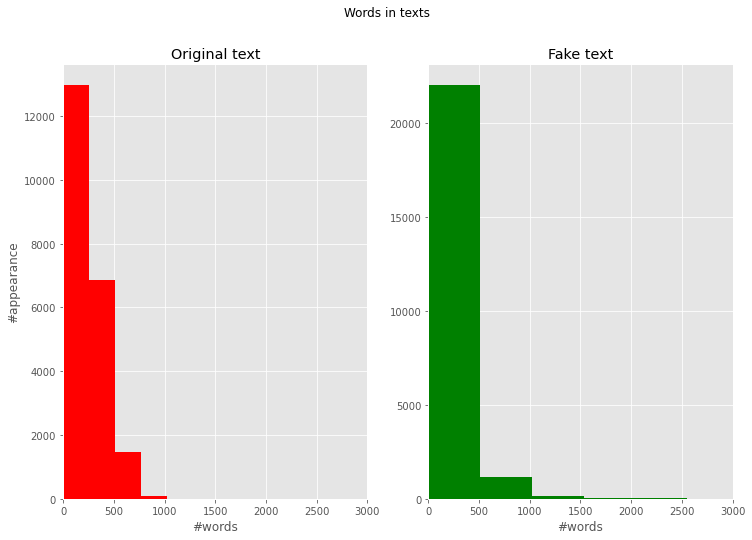

In [107]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,8))
text_len=news_df[news_df['class']==1]['text'].str.split().map(lambda x: len(x))
ax1.hist(text_len,color='red')
ax1.set_title('Original text')
ax1.set_xlim(0, 3000)
ax1.set_xlabel('#words')
ax1.set_ylabel('#appearance')
text_len=news_df[news_df['class']==0]['text'].str.split().map(lambda x: len(x))
ax2.hist(text_len,color='green')
ax2.set_title('Fake text')
ax2.set_xlim(0, 3000)
ax2.set_xlabel('#words')
fig.suptitle('Words in texts')
plt.show()

From the above figures we find that **words** in true/false texts are of different distributions. Both fake and true news apear the most in 0-1000 words region, but fake news have more appearances. Fake news also tend to be longer since it has distribution when #words exceed 2000. 

**Average word length in a text**

/Users/jianyu/opt/anaconda3/envs/dml/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/jianyu/opt/anaconda3/envs/dml/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/jianyu/opt/anaconda3/envs/dml/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/jianyu/opt/anaconda3/envs/dml/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexi

Text(0.5, 0.98, 'Average word length in each text')

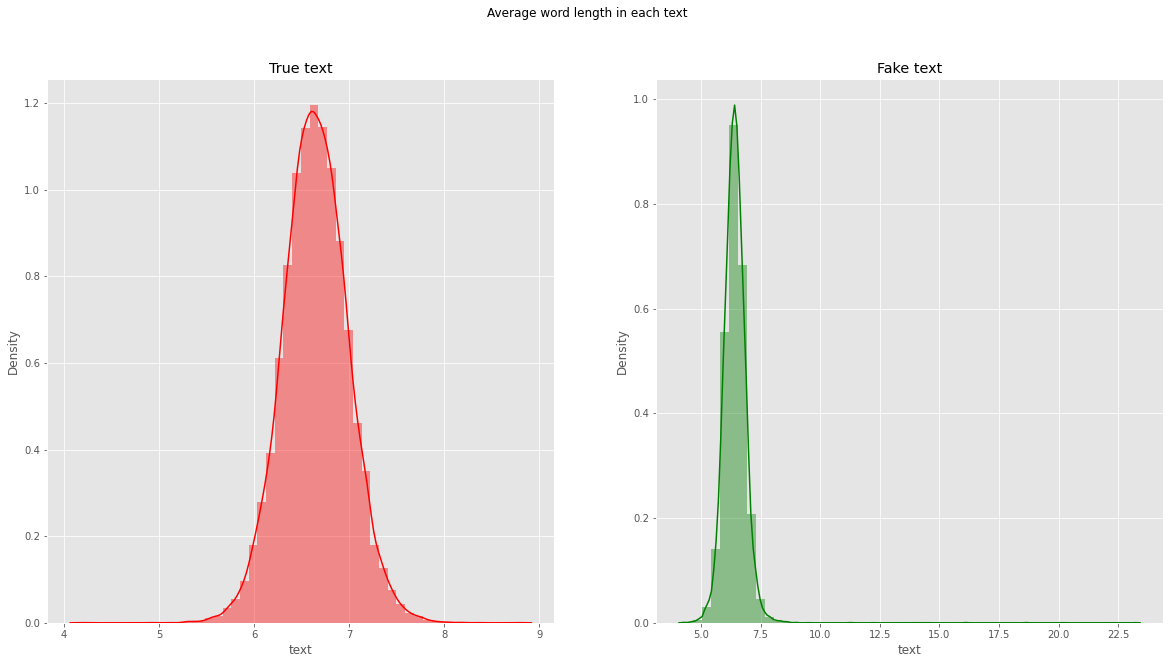

In [108]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(20,10))
word=news_df[news_df['class']==1]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='red')
ax1.set_title('True text')
word=news_df[news_df['class']==0]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='green')
ax2.set_title('Fake text')
fig.suptitle('Average word length in each text')

From the above figures we find that **average word length** in true/false texts are of different distributions. True news has a normal distribution while fake news has a different distribution.

**Unigram Analysis**

In [118]:
def get_corpus(text):
    words = []
    for i in text:
        for j in i.split():
            words.append(j.strip())
    return words
corpus = get_corpus(news_df.text)

In [119]:
from collections import Counter
counter = Counter(corpus)
most_common = counter.most_common(10)
most_common = dict(most_common)
most_common

{'s': 172181,
 'Trump': 110740,
 'said': 93161,
 'U.S.': 50340,
 'will': 48646,
 't': 41973,
 'people': 33107,
 'President': 32937,
 '-': 31476,
 'one': 29365}

In [128]:
import os
home_path = os.getcwd()
news_df.to_csv('/Users/jianyu/Documents/GitHub/FakeNewsProject/cleaned_data.csv')

# Train

In [129]:
features = news_df['text']
targets = news_df['class']

X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.20, random_state=18)

In [130]:
def normalize(data):
    normalized = []
    for i in data:
        i = i.lower()
        # get rid of urls
        i = re.sub('https?://\S+|www\.\S+', '', i)
        # get rid of non words and extra spaces
        i = re.sub('\\W', ' ', i)
        i = re.sub('\n', '', i)
        i = re.sub(' +', ' ', i)
        i = re.sub('^ ', '', i)
        i = re.sub(' $', '', i)
        normalized.append(i)
    return normalized

X_train = normalize(X_train)
X_test = normalize(X_test)

**tokenizer**

In [131]:
max_vocab = 10000
tokenizer = Tokenizer(num_words=max_vocab)
tokenizer.fit_on_texts(X_train)

In [132]:
# tokenize the text into vectors 
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [133]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, padding='post', maxlen=256)
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, padding='post', maxlen=256)

In [134]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_vocab, 32),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 32)          320000    
_________________________________________________________________
bidirectional (Bidirectional (None, None, 128)         49664     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 32)                18560     
_________________________________________________________________
dense (Dense)                (None, 64)                2112      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 390,401
Trainable params: 390,401
Non-trainable params: 0
__________________________________________________

In [33]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=10,validation_split=0.1, batch_size=30, shuffle=True, callbacks=[early_stop])

Epoch 1/10
1078/1078 [==============================] - 295s 267ms/step - loss: 0.5088 - accuracy: 0.6946 - val_loss: 0.2192 - val_accuracy: 0.9301
Epoch 2/10
1078/1078 [==============================] - 287s 266ms/step - loss: 0.2155 - accuracy: 0.9303 - val_loss: 0.1890 - val_accuracy: 0.9332
Epoch 3/10
1078/1078 [==============================] - 258s 239ms/step - loss: 0.1604 - accuracy: 0.9427 - val_loss: 0.1099 - val_accuracy: 0.9577
Epoch 4/10
1078/1078 [==============================] - 255s 237ms/step - loss: 0.0815 - accuracy: 0.9768 - val_loss: 0.0827 - val_accuracy: 0.9730
Epoch 5/10
1078/1078 [==============================] - 272s 252ms/step - loss: 0.0562 - accuracy: 0.9812 - val_loss: 0.0749 - val_accuracy: 0.9788
Epoch 6/10
1078/1078 [==============================] - 315s 292ms/step - loss: 0.0356 - accuracy: 0.9893 - val_loss: 0.0604 - val_accuracy: 0.9797
Epoch 7/10
1078/1078 [==============================] - 273s 253ms/step - loss: 0.0358 - accuracy: 0.9893 - val_

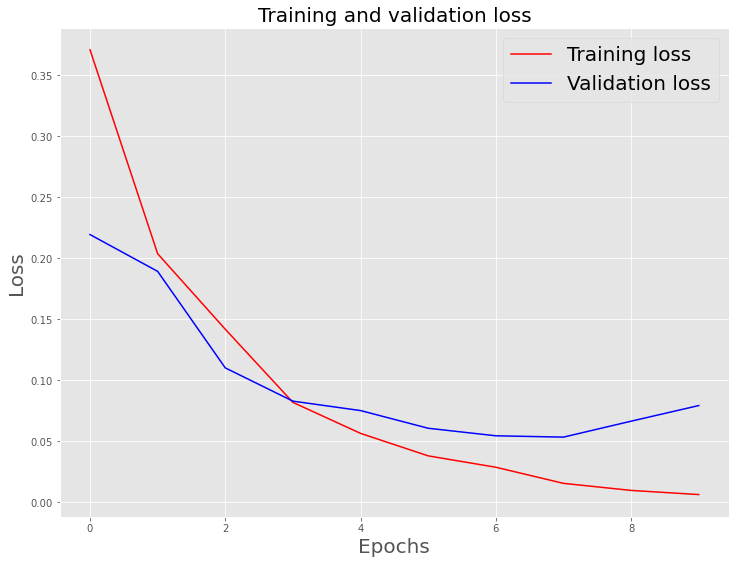

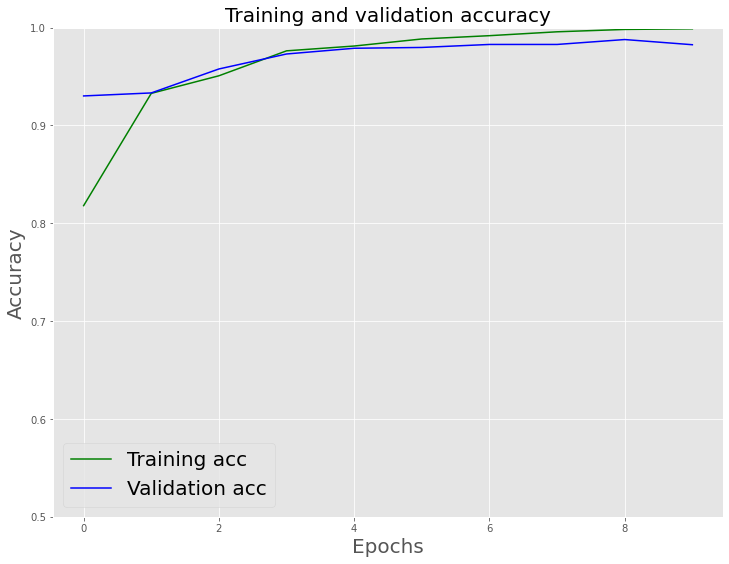

In [34]:
history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = history.epoch

plt.figure(figsize=(12,9))
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss', size=20)
plt.xlabel('Epochs', size=20)
plt.ylabel('Loss', size=20)
plt.legend(prop={'size': 20})
plt.show()

plt.figure(figsize=(12,9))
plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy', size=20)
plt.xlabel('Epochs', size=20)
plt.ylabel('Accuracy', size=20)
plt.legend(prop={'size': 20})
plt.ylim((0.5,1))
plt.show()

In [35]:
model.evaluate(X_test, y_test)

281/281 [==============================] - 20s 73ms/step - loss: 0.0554 - accuracy: 0.9825


[0.055421099066734314, 0.9825167059898376]

In [36]:
pred = model.predict(X_test)

binary_predictions = []

for i in pred:
    if i >= 0.5:
        binary_predictions.append(1)
    else:
        binary_predictions.append(0) 

In [37]:
print('Accuracy on testing set:', accuracy_score(binary_predictions, y_test))
print('Precision on testing set:', precision_score(binary_predictions, y_test))
print('Recall on testing set:', recall_score(binary_predictions, y_test))

Accuracy on testing set: 0.9825167037861915
Precision on testing set: 0.9775358962482631
Recall on testing set: 0.9859845830413455


[Text(0, 0.5, '0'), Text(0, 1.5, '1')]

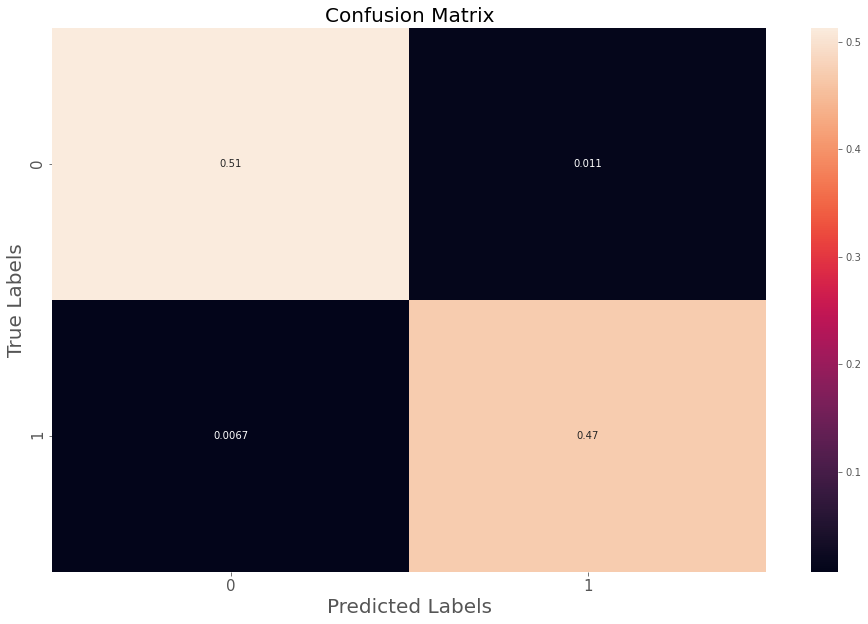

In [38]:
matrix = confusion_matrix(binary_predictions, y_test, normalize='all')
plt.figure(figsize=(16, 10))
ax= plt.subplot()
sns.heatmap(matrix, annot=True, ax = ax)

# labels, title and ticks
ax.set_xlabel('Predicted Labels', size=20)
ax.set_ylabel('True Labels', size=20)
ax.set_title('Confusion Matrix', size=20) 
ax.xaxis.set_ticklabels([0,1], size=15)
ax.yaxis.set_ticklabels([0,1], size=15)

In [39]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

(10000, 32)


In [40]:
word_index = list(tokenizer.word_index.keys())
word_index = word_index[:max_vocab-1]

In [41]:
import io

out_v = io.open('fakenews_vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('fakenews_meta.tsv', 'w', encoding='utf-8')

for num, word in enumerate(word_index):
  vec = weights[num+1] # skip 0, it's padding.
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
out_v.close()
out_m.close()

# On GRU

In [147]:
GRUmodel = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_vocab, 32),
    tf.keras.layers.GRU(128, return_sequences=True),
    tf.keras.layers.GRU(64),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

GRUmodel.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
gru_10 (GRU)                 (None, None, 128)         62208     
_________________________________________________________________
gru_11 (GRU)                 (None, 64)                37248     
_________________________________________________________________
dense_11 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_6 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 65        
Total params: 423,681
Trainable params: 423,681
Non-trainable params: 0
________________________________________________

In [150]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
GRUmodel.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

history = GRUmodel.fit(X_train, y_train, epochs=10,validation_split=0.1, batch_size=30, shuffle=True, callbacks=[early_stop])

Epoch 1/10
1078/1078 [==============================] - 178s 165ms/step - loss: 0.4851 - accuracy: 0.7540 - val_loss: 0.6912 - val_accuracy: 0.5390
Epoch 2/10
1078/1078 [==============================] - 171s 159ms/step - loss: 0.6971 - accuracy: 0.5221 - val_loss: 0.6905 - val_accuracy: 0.5390
Epoch 3/10
1078/1078 [==============================] - 168s 155ms/step - loss: 0.6925 - accuracy: 0.5223 - val_loss: 0.6903 - val_accuracy: 0.5390
Epoch 4/10
1078/1078 [==============================] - 165s 153ms/step - loss: 0.6924 - accuracy: 0.5223 - val_loss: 0.6910 - val_accuracy: 0.5390
Epoch 5/10
1078/1078 [==============================] - 169s 157ms/step - loss: 0.6913 - accuracy: 0.5319 - val_loss: 0.6469 - val_accuracy: 0.7817
Epoch 6/10
1078/1078 [==============================] - 168s 156ms/step - loss: 0.3529 - accuracy: 0.8688 - val_loss: 0.2394 - val_accuracy: 0.9296
Epoch 7/10
1078/1078 [==============================] - 168s 156ms/step - loss: 0.2138 - accuracy: 0.9426 - val_

In [151]:
GRUmodel.evaluate(X_test, y_test)

281/281 [==============================] - 11s 39ms/step - loss: 0.1466 - accuracy: 0.9584


[0.14659260213375092, 0.9583519101142883]

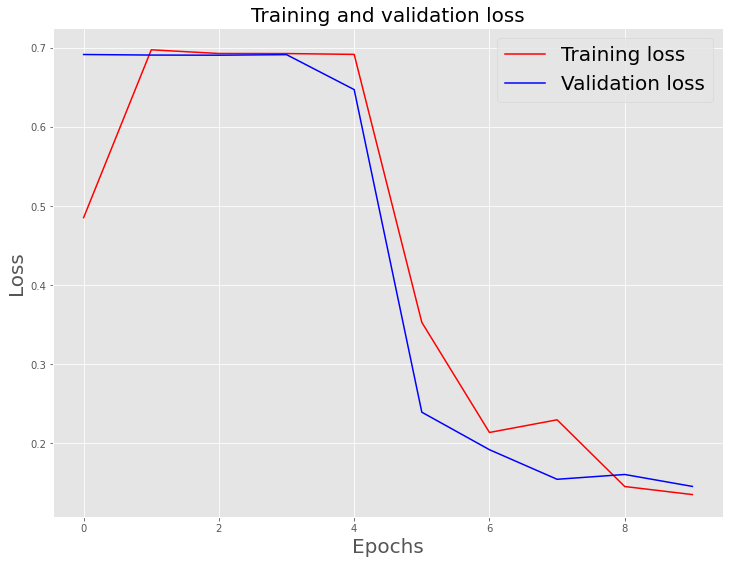

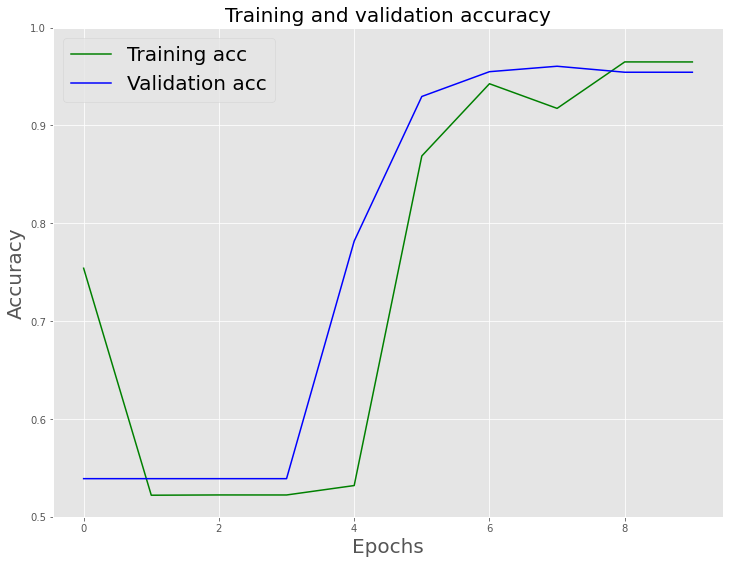

In [153]:
history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = history.epoch

plt.figure(figsize=(12,9))
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss', size=20)
plt.xlabel('Epochs', size=20)
plt.ylabel('Loss', size=20)
plt.legend(prop={'size': 20})
plt.show()

plt.figure(figsize=(12,9))
plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy', size=20)
plt.xlabel('Epochs', size=20)
plt.ylabel('Accuracy', size=20)
plt.legend(prop={'size': 20})
plt.ylim((0.5,1))
plt.show()

Accuracy on testing set: 0.9583518930957684
Precision on testing set: 0.9877257989810098
Recall on testing set: 0.930004361098997


[Text(0, 0.5, '0'), Text(0, 1.5, '1')]

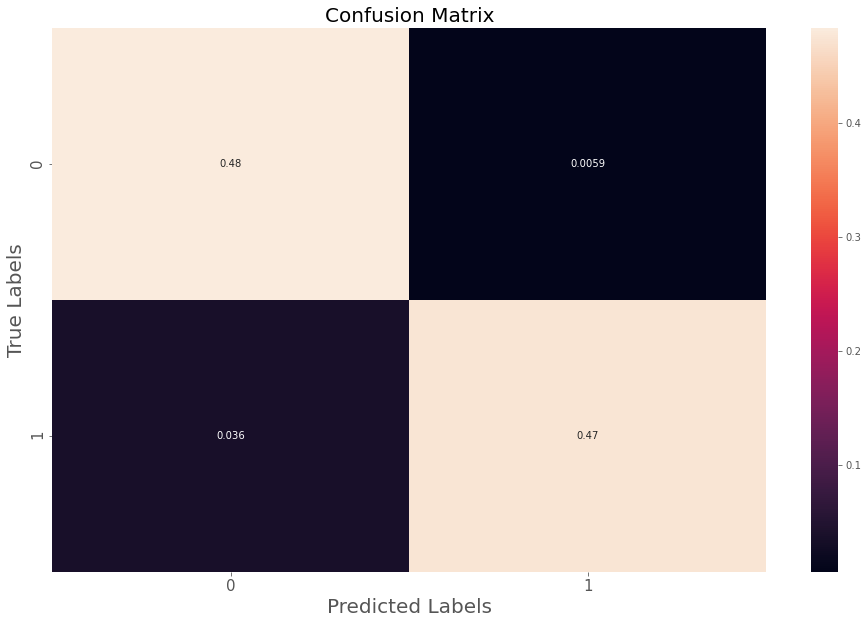

In [176]:
pred = GRUmodel.predict(X_test)

binary_predictions = []

for i in pred:
    if i >= 0.5:
        binary_predictions.append(1)
    else:
        binary_predictions.append(0) 
        
print('Accuracy on testing set:', accuracy_score(binary_predictions, y_test))
print('Precision on testing set:', precision_score(binary_predictions, y_test))
print('Recall on testing set:', recall_score(binary_predictions, y_test))

matrix = confusion_matrix(binary_predictions, y_test, normalize='all')
plt.figure(figsize=(16, 10))
ax= plt.subplot()
sns.heatmap(matrix, annot=True, ax = ax)

# labels, title and ticks
ax.set_xlabel('Predicted Labels', size=20)
ax.set_ylabel('True Labels', size=20)
ax.set_title('Confusion Matrix', size=20) 
ax.xaxis.set_ticklabels([0,1], size=15)
ax.yaxis.set_ticklabels([0,1], size=15)

# Transformer

In [162]:
from tensorflow.keras import layers
from tensorflow import keras
class MultiHeadSelfAttention(layers.Layer):
    def __init__(self, embed_dim, num_heads=8):
        super(MultiHeadSelfAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        if embed_dim % num_heads != 0:
            raise ValueError(
                f"embedding dimension = {embed_dim} should be divisible by number of heads = {num_heads}"
            )
        self.projection_dim = embed_dim // num_heads
        self.query_dense = layers.Dense(embed_dim)
        self.key_dense = layers.Dense(embed_dim)
        self.value_dense = layers.Dense(embed_dim)
        self.combine_heads = layers.Dense(embed_dim)

    def attention(self, query, key, value):
        score = tf.matmul(query, key, transpose_b=True)
        dim_key = tf.cast(tf.shape(key)[-1], tf.float32)
        scaled_score = score / tf.math.sqrt(dim_key)
        weights = tf.nn.softmax(scaled_score, axis=-1)
        output = tf.matmul(weights, value)
        return output, weights

    def separate_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs):
        # x.shape = [batch_size, seq_len, embedding_dim]
        batch_size = tf.shape(inputs)[0]
        query = self.query_dense(inputs)  # (batch_size, seq_len, embed_dim)
        key = self.key_dense(inputs)  # (batch_size, seq_len, embed_dim)
        value = self.value_dense(inputs)  # (batch_size, seq_len, embed_dim)
        query = self.separate_heads(
            query, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        key = self.separate_heads(
            key, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        value = self.separate_heads(
            value, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        attention, weights = self.attention(query, key, value)
        attention = tf.transpose(
            attention, perm=[0, 2, 1, 3]
        )  # (batch_size, seq_len, num_heads, projection_dim)
        concat_attention = tf.reshape(
            attention, (batch_size, -1, self.embed_dim)
        )  # (batch_size, seq_len, embed_dim)
        output = self.combine_heads(
            concat_attention
        )  # (batch_size, seq_len, embed_dim)
        return output

    
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadSelfAttention(embed_dim, num_heads)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)


In [170]:
embed_dim = 32
num_heads = 1
ff_dim = 32
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
transformr_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_vocab, 32),
    transformer_block,
    layers.GlobalAveragePooling1D(),
    layers.Dropout(0.1),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

transformr_model.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, None, 32)          320000    
_________________________________________________________________
transformer_block_7 (Transfo (None, None, 32)          6464      
_________________________________________________________________
global_average_pooling1d (Gl (None, 32)                0         
_________________________________________________________________
dropout_24 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_63 (Dense)             (None, 32)                1056      
_________________________________________________________________
dropout_25 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_64 (Dense)             (None, 1)               

In [171]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
transformr_model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

history = transformr_model.fit(X_train, y_train, epochs=10,validation_split=0.1, batch_size=30, shuffle=True, callbacks=[early_stop])

Epoch 1/10
1078/1078 [==============================] - 43s 40ms/step - loss: 0.2700 - accuracy: 0.8730 - val_loss: 0.0443 - val_accuracy: 0.9839
Epoch 2/10
1078/1078 [==============================] - 43s 40ms/step - loss: 0.0420 - accuracy: 0.9904 - val_loss: 0.0257 - val_accuracy: 0.9930
Epoch 3/10
1078/1078 [==============================] - 43s 40ms/step - loss: 0.0189 - accuracy: 0.9968 - val_loss: 0.0255 - val_accuracy: 0.9925
Epoch 4/10
1078/1078 [==============================] - 43s 40ms/step - loss: 0.0096 - accuracy: 0.9983 - val_loss: 0.0244 - val_accuracy: 0.9950
Epoch 5/10
1078/1078 [==============================] - 43s 40ms/step - loss: 0.0073 - accuracy: 0.9989 - val_loss: 0.0213 - val_accuracy: 0.9953
Epoch 6/10
1078/1078 [==============================] - 43s 40ms/step - loss: 0.0033 - accuracy: 0.9997 - val_loss: 0.0246 - val_accuracy: 0.9953
Epoch 7/10
1078/1078 [==============================] - 43s 40ms/step - loss: 0.0026 - accuracy: 0.9998 - val_loss: 0.0274 -

In [172]:
transformr_model.evaluate(X_test, y_test)

281/281 [==============================] - 5s 16ms/step - loss: 0.0234 - accuracy: 0.9941


[0.02336481772363186, 0.9940980076789856]

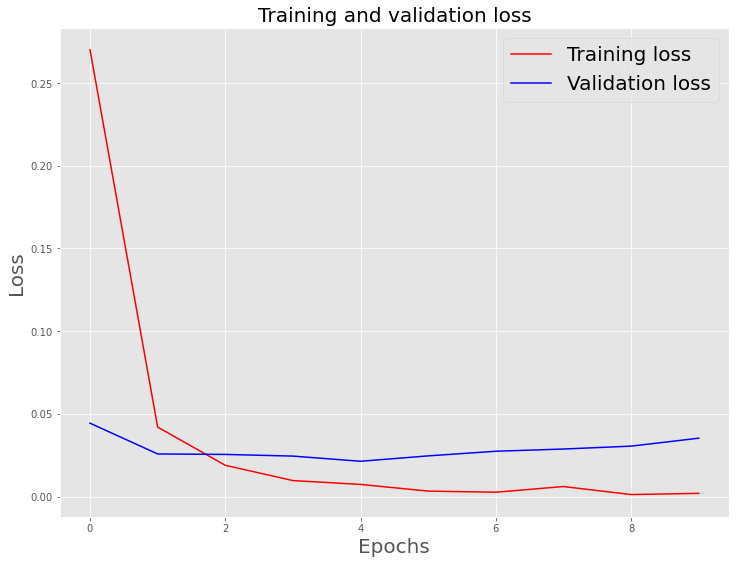

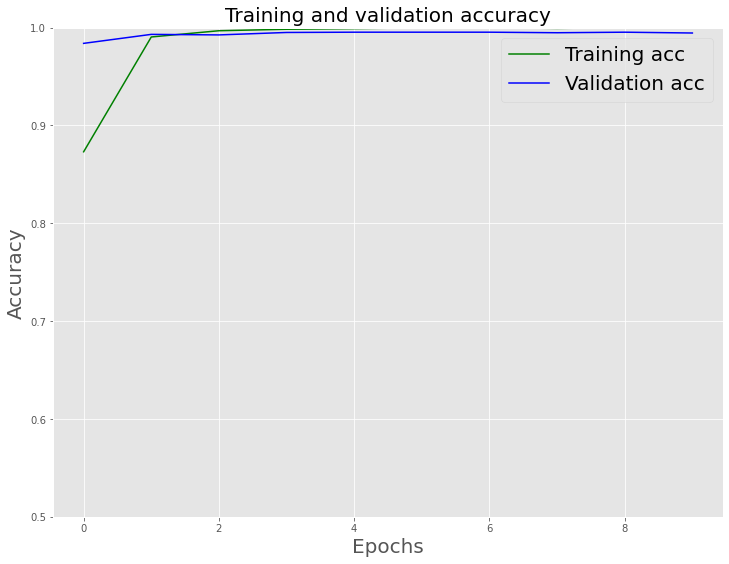

In [173]:
history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = history.epoch

plt.figure(figsize=(12,9))
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss', size=20)
plt.xlabel('Epochs', size=20)
plt.ylabel('Loss', size=20)
plt.legend(prop={'size': 20})
plt.show()

plt.figure(figsize=(12,9))
plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy', size=20)
plt.xlabel('Epochs', size=20)
plt.ylabel('Accuracy', size=20)
plt.legend(prop={'size': 20})
plt.ylim((0.5,1))
plt.show()

Accuracy on testing set: 0.994097995545657
Precision on testing set: 0.99235757295044
Recall on testing set: 0.9953542392566783


[Text(0, 0.5, '0'), Text(0, 1.5, '1')]

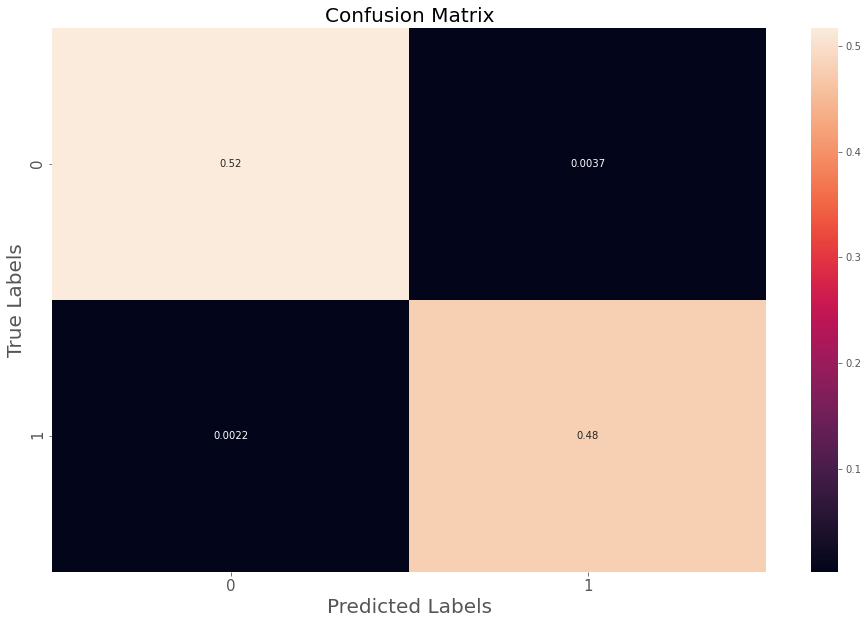

In [175]:
pred = transformr_model.predict(X_test)

binary_predictions = []

for i in pred:
    if i >= 0.5:
        binary_predictions.append(1)
    else:
        binary_predictions.append(0) 
        
print('Accuracy on testing set:', accuracy_score(binary_predictions, y_test))
print('Precision on testing set:', precision_score(binary_predictions, y_test))
print('Recall on testing set:', recall_score(binary_predictions, y_test))

matrix = confusion_matrix(binary_predictions, y_test, normalize='all')
plt.figure(figsize=(16, 10))
ax= plt.subplot()
sns.heatmap(matrix, annot=True, ax = ax)

# labels, title and ticks
ax.set_xlabel('Predicted Labels', size=20)
ax.set_ylabel('True Labels', size=20)
ax.set_title('Confusion Matrix', size=20) 
ax.xaxis.set_ticklabels([0,1], size=15)
ax.yaxis.set_ticklabels([0,1], size=15)